In [1]:
import pandas as pd
import numpy as np
import geopandas
import matplotlib.colors as colors
import math
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import plotly.express as px
import pickle

from module.variables import *
from module.functions import *

In [2]:
#EU 2020 population and Ophthalmology Data
with open('eu_two_letter.pickle', 'rb') as handle:
    l2c = pickle.load(handle)
EU_pop = pd.read_csv('EU_Pop.csv')


with open('specialty_state_positions.pickle', 'rb') as handle:
    residency_state = pickle.load(handle)

In [3]:
uk2017 = '3.79(0.04) Czech Republic(CZ) 2.56 Greece(GR) 1.93(0.05) Switzerland(CH) 1.28(0.13) Romania(RO) 1.26 Cyprus(CY) 1.2 Ukraine(UA) 1.15(0.08) Italy(IT) 1.12(0.34) Austria(AT) 1.09(‐0.01) Poland(PL) 1.07(0.05) Latvia(LV) 0.95(0.1) Portugal(PT) 0.95(‐0.29) Bulgaria(BG) 0.93(‐0.02) Belgium(BE) 0.92(0.04) France(FR) 0.91(‐0.02) Estonia(EE) 0.82(‐0.28) Finland(FI) 0.81(0.02) Germany(DE) 0.8(0.01) Croatia(HR) 0.77(‐0.09) Spain(ES) 0.73(0.05) Serbia(RS) 0.73(0.02) Norway(NO) 0.73 Slovenia(SI) 0.66(‐0.02) Sweden(SE) 0.62(‐0.01) Denmark(DK) 0.61(0.01) Hungary(HU) 0.46(0.13) Turkey(TR) 0.42(‐0.01) Netherlands(NL) 0.38(‐0.02) United Kingdom(GB) 0.32(‐0.01)'
uk2017 = uk2017.split(") ")
uk2017 = [x.split("(") for x in uk2017] + [["Ireland", "IE"]]
uk2017_final = []
x = 0
while x < len(uk2017):
    group = uk2017[x]
    try:
        # print(group)
        float(group[0])
        uk2017_final.append( (group[0], uk2017[x+1][0], uk2017[x+1][1]) )
        x += 2
    except:
        other  = group[0].split(" ")
        print(other)
        # print(group)
        uk2017_final.append( (other[0], other[1], group[1]) )  
        x += 1    

uk2017_pd = pd.DataFrame(columns=["NAME_0", "ABV", "per_10k_2017"])

for x in uk2017_final:
    temp = pd.DataFrame(data = [[x[1], x[2], x[0]]], columns = ["NAME", "ABV", "per_10k_2017"])
    uk2017_pd = pd.concat([uk2017_pd, temp])


['2.56', 'Greece']
['1.26', 'Cyprus']
['1.2', 'Ukraine']
['0.73', 'Slovenia']


In [4]:
region_to_name = pd.DataFrame([uk_regions, uk_names]).T
region_to_name.columns = ["ABR", "NAME_1"]

In [5]:
providers = pd.DataFrame(uk_data).T
providers.columns = ["Providers", "NAME_1", "Population", "Compensation1"]
providers["Compensation1"] = providers["Compensation1"].astype("float")

In [6]:
state_to_state = pull_all(10, [2017, 2018], uk_regions, "UK").mean()
state_to_state = pd.DataFrame(state_to_state)
state_to_state.reset_index(inplace=True)
state_to_state.columns = ["ABR", "Interest_18"]
state_to_state = state_to_state.merge(region_to_name, on="ABR")
states = geopandas.read_file('GBR_adm/GBR_adm1.shp')
states = states.merge(state_to_state, on="NAME_1")
states = states.merge(providers, on="NAME_1")
states["Rate_100k_18"] = states["Providers"]/states["Population"] * 100000
states["Rate_100k_18"] = states["Rate_100k_18"].astype('float64')
states["Need_18"] = states["Interest_18"]/states["Rate_100k_18"]
states

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry,ABR,Interest_18,Providers,Population,Compensation1,Rate_100k_18,Need_18
0,242,GBR,United Kingdom,1,England,Home Nation|Constituent Country,Kingdom,None,None,"MULTIPOLYGON (((-6.38792 49.86875, -6.38792 49...",ENG,56.169231,12601,55977000,79860.0,22.511031,2.495187
1,242,GBR,United Kingdom,2,Northern Ireland,Home Nation|Constituent Country,Province,None,Ulster,"MULTIPOLYGON (((-6.09417 54.05153, -6.09417 54...",NIR,13.646154,35.892,1876000,78296.0,1.913220,7.132560
2,242,GBR,United Kingdom,3,Scotland,Home Nation|Constituent Country,Kingdom,None,Alba,"MULTIPOLYGON (((-4.70083 54.66570, -4.70083 54...",SCT,38.861538,1263,5437000,77779.0,23.229722,1.672923
3,242,GBR,United Kingdom,4,Wales,Home Nation|Constituent Country,Principality,None,Cymru,"MULTIPOLYGON (((-3.10472 51.34153, -3.10472 51...",WLS,15.138462,61.14,3127000,82669.0,1.955229,7.742553


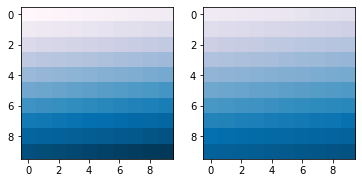

In [7]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)
cmap = plt.get_cmap('PuBu')
# cmap = plt.get_cmap('seismic')
new_cmap = truncate_colormap(cmap, 0.1, 0.9)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

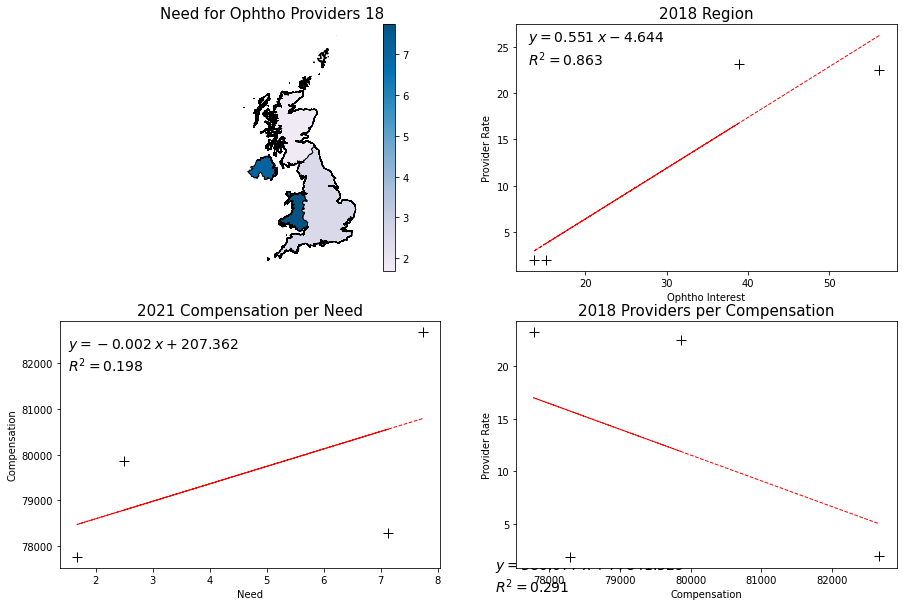

In [8]:
# Geo Map by State
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
ax1.axis('off')
ax1.set_title('Need for Ophtho Providers 18', fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column='Need_18',
          cmap=new_cmap,
          linewidth=0.9,
            ax=ax1,
            edgecolor='0',
            legend=True)

#Scatter by State
ax3.set_title('2018 Region', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax3.set_xlabel("Ophtho Interest")
ax3.set_ylabel("Provider Rate")
x = states["Interest_18"]
y = states["Rate_100k_18"]

ax3.plot(x,y,"+", 
         ms=10, 
         mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax3.plot(x, y_hat, 
         "r--",
         lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax3.text(13, 27, text,
     fontsize=14, verticalalignment='top')

#Scatter by State
ax4.set_title('2018 Providers per Compensation', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax4.set_xlabel("Compensation")
ax4.set_ylabel("Provider Rate")
x = states["Compensation1"]
y = states["Rate_100k_18"]

ax4.plot(x,y,"+", 
         ms=10, 
         mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax4.plot(x, y_hat, 
         "r--",
         lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax4.text(71200, 19.5, text,
     fontsize=14)


#Scatter by State
ax2.set_title('2021 Compensation per Need', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax2.set_xlabel("Need")
ax2.set_ylabel("Compensation")
x = states["Need_18"]
y = states["Compensation1"]

ax2.plot(x,y,"+", 
         ms=10, 
         mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax2.plot(x, y_hat, 
         "r--",
         lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax2.text(9, 77000, text,
     fontsize=14)


fig.savefig('Figures/UK.png')

Text(13, 27, '$y=0.551\\;x-4.644$\n$R^2 = 0.863$')

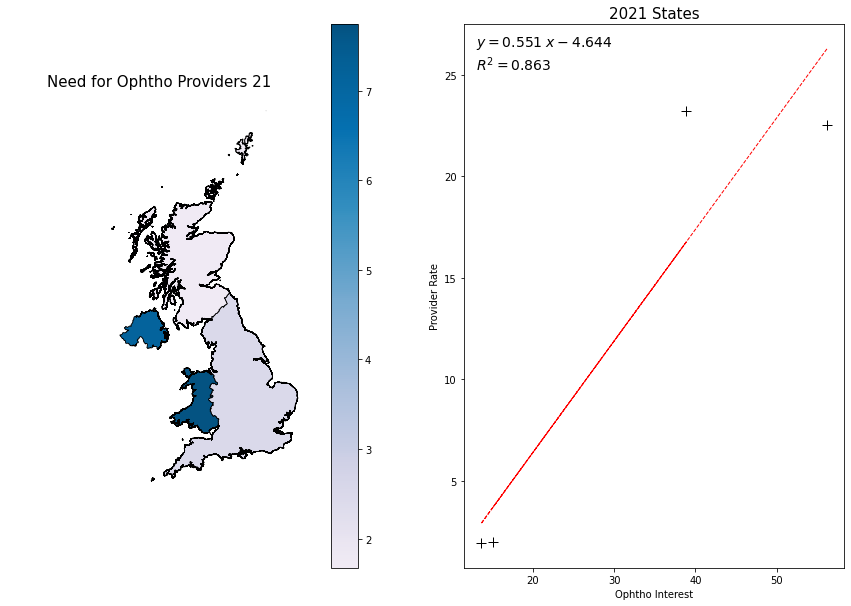

In [9]:
# Geo Map by State
fig, ((ax1, ax3)) = plt.subplots(1, 2, figsize=(15, 10))
ax1.axis('off')
ax1.set_title('Need for Ophtho Providers 21', fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column='Need_18',
          cmap=new_cmap,
          linewidth=0.9,
            ax=ax1,
            edgecolor='0',
            legend=True)

#Scatter by State
ax3.set_title('2021 States', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax3.set_xlabel("Ophtho Interest")
ax3.set_ylabel("Provider Rate")
x = states["Interest_18"]
y = states["Rate_100k_18"]

ax3.plot(x,y,"+", 
         ms=10, 
         mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax3.plot(x, y_hat, 
         "r--",
         lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax3.text(13, 27, text,
     fontsize=14, verticalalignment='top')


# fig.savefig('Figures/2021.png')

In [10]:
#Parse 2020 ophthalmology Data for EU
labels = 'AT 0,80 BE 0,88 BG 1,03 HR 0,95 CY 1,40 CZ 0,99 DK 0,50 EE 1,21 FI 0,89 FR 0,88 DE 0,49 GR 2,80 HU 1,02 IE 0,69 IT 1,26 LV 1,14 LT 1,23 NL 0,38 MK 0,14 NO 1,04 PO 1,24 RO 1,28 RS 0,93 SI 0,71 ES 0,89 SE 0,79 CH 1,38 TR 0,44 UK 0,22'
labels = labels.split(" ")
counteries = [labels[x] for x in range(0, len(labels), 2) ]
per_10k = [labels[x].replace(",", ".") for x in range(1, len(labels), 2) ]

EU = pd.DataFrame(columns=["Country","per_10k"])

for x in range(len(counteries)):
    country = l2c[counteries[x]]
    temp = pd.DataFrame(data=[[country, per_10k[x]]], columns=["Country", "per_10k"])
    EU = pd.concat([EU, temp])

EU = EU.merge(EU_pop, on="Country")

EU["per_10k"] = EU["per_10k"].astype(float)
EU["Population"] = EU["Population"].astype(int)
EU["Ophthalmologists"] = EU["per_10k"]*EU["Population"]/10000
EU["Rate_100k_2020"] = EU["per_10k"]*10
EU["Ophthalmologists"] = EU["Ophthalmologists"].apply(np.floor).astype(int)
EU = EU.drop("per_10k", axis=1)
EU = EU.rename(columns = {'Country':'NAME'})

EU = EU.merge(uk2017_pd, on="NAME")
EU["per_10k_2017"] = EU["per_10k_2017"].astype(float)
EU["Rate_100k_2017"] = EU["per_10k_2017"]*10
EU["Rate_100k_change"] = (EU["Rate_100k_2020"] - EU["Rate_100k_2017"])/EU["Rate_100k_2017"] * 100
EU = EU.drop(["NAME_0", "ABV", "per_10k_2017"], axis = 1)

In [11]:
EU_countries = pull_all(10, [2019, 2020], EU_regions, "EU").mean()
EU_countries = pd.DataFrame(EU_countries)
EU_countries.reset_index(inplace=True)
EU_countries.columns = ["ABR", "Interest_20"]
EU_countries["NAME"] = ""
for index, row in EU_countries.iterrows():
    if EU_countries.loc[index,"ABR"] == "PL":
        EU_countries.loc[index,"ABR"] = "PO"
    if EU_countries.loc[index,"ABR"] == "GB":
        EU_countries.loc[index,"ABR"] = "UK"
    EU_countries.loc[index,"NAME"] = l2c[EU_countries.loc[index,"ABR"]]

# EU_countries

In [12]:
europe = geopandas.read_file('Europe_borders\Europe_borders.shp')
europe = europe.merge(EU, on="NAME", how='left')
europe = europe.merge(EU_countries, on="NAME", how='left')
europe = europe.fillna(0)
europe = europe[(europe.NAME != "Faeroe Islands (Denmark)") & (europe.NAME != "Jan Mayen (Norway)") & (europe.NAME != "Svalbard (Norway)") &\
        (europe.NAME != "Russia") & (europe.NAME != "Gibraltar (UK)") & (europe.NAME != "Iceland")]

In [13]:
europe["Need_21"] = europe["Interest_20"]/europe["Rate_100k_2020"]
europe = europe.sort_values(by="Rate_100k_change", ascending = True)
europe

,NAME,ORGN_NAME,geometry,Population,Ophthalmologists,Rate_100k_2020,Rate_100k_2017,Rate_100k_change,ABR,Interest_20,Need_21
35,United Kingdom,United Kingdom,"MULTIPOLYGON (((-5.33523 51.85830, -5.34557 51...",67326569.0,1481.0,2.2,3.8,-42.105263,UK,59.384615,26.993007
11,Germany,Deutschland,"MULTIPOLYGON (((13.11717 54.54924, 13.12529 54...",83783942.0,4105.0,4.9,8.1,-39.506173,DE,32.523077,6.637363
2,Austria,Österreich,"POLYGON ((16.00000 48.77775, 16.00000 48.78252...",9006398.0,720.0,8.0,11.2,-28.571429,AT,14.884615,1.860577
34,Switzerland,Schweiz / Suisse / Svizerra / Svizra,"POLYGON ((9.53591 47.27354, 9.52660 47.25858, ...",8697723.0,1200.0,13.8,19.3,-28.497409,CH,22.192308,1.608138
7,Denmark,Danmark,"MULTIPOLYGON (((11.99978 54.94118, 11.98534 54...",5792202.0,289.0,5.0,6.2,-19.354839,DK,24.102564,4.820513
25,Netherlands,Nederland,"MULTIPOLYGON (((6.05039 53.44675, 6.04538 53.4...",17134872.0,651.0,3.8,4.2,-9.523810,NL,26.246154,6.906883
3,Belgium,België / Belgique,"POLYGON ((5.00000 49.79374, 4.99724 49.79696, ...",11589623.0,1019.0,8.8,9.3,-5.376344,BE,25.596154,2.908654
10,France,France,"MULTIPOLYGON (((-2.28137 46.68570, -2.31121 46...",65273511.0,5744.0,8.8,9.2,-4.347826,FR,16.523077,1.877622
47,Turkey,Türkiye,"MULTIPOLYGON (((29.11932 40.83066, 29.11734 40...",85042736.0,3741.0,4.4,4.6,-4.347826,TR,4.692308,1.066434
31,Slovenia,Slovenija,"POLYGON ((16.56602 46.48372, 16.54178 46.48717...",2078938.0,147.0,7.1,7.3,-2.739726,SI,13.282051,1.870711


c:\Users\aidan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\colors.py:1254: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


Text(35, 27, '$y=0.165\\;x+3.631$\n$R^2 = 0.119$')

c:\Users\aidan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\colors.py:1254: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


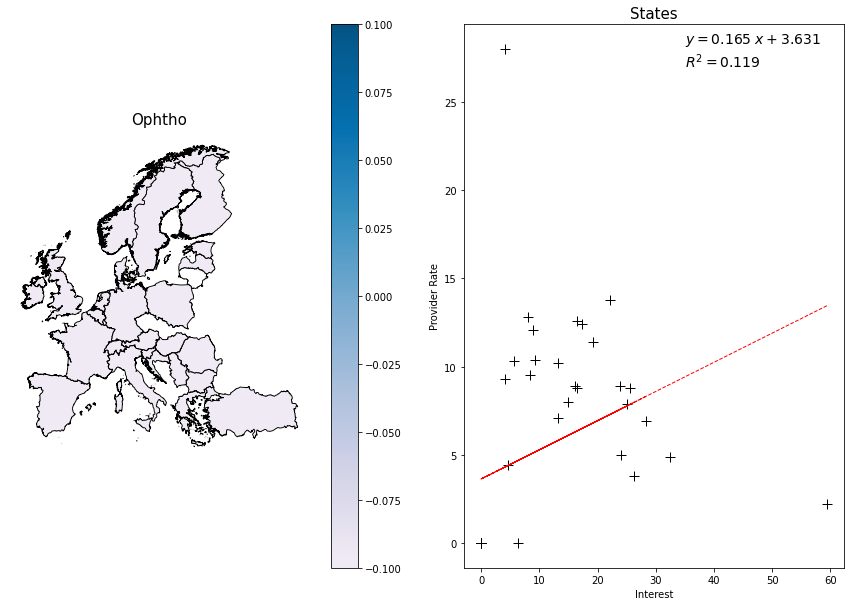

In [14]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 10))
ax1.axis('off')
ax1.set_title("Ophtho", fontdict={'fontsize': '15', 'fontweight' : '3'})
europe.plot(column="Need_21",
        cmap=new_cmap,
        linewidth=0.9,
        ax=ax1,
        edgecolor='0',
        legend=True)

ax3.set_title('States', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax3.set_xlabel("Interest")
ax3.set_ylabel("Provider Rate")
x = europe["Interest_20"]
y = europe["Rate_100k_2020"]

ax3.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax3.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax3.text(35, 27, text,
fontsize=14)

c:\Users\aidan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\colors.py:1254: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


Text(20, 0, '$y=0.321\\;x+1.926$\n$R^2 = 0.431$')

c:\Users\aidan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\colors.py:1254: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


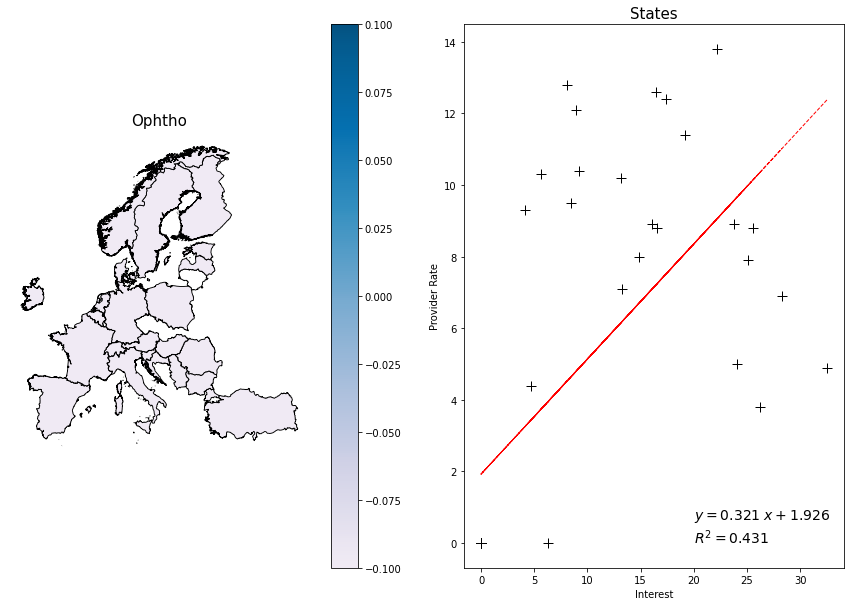

In [15]:
europe2 = europe[(europe.NAME != "United Kingdom") & (europe.NAME != "Greece")]
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 10))
ax1.axis('off')
ax1.set_title("Ophtho", fontdict={'fontsize': '15', 'fontweight' : '3'})
europe2.plot(column="Need_21",
        cmap=new_cmap,
        linewidth=0.9,
        ax=ax1,
        edgecolor='0',
        legend=True)

ax3.set_title('States', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax3.set_xlabel("Interest")
ax3.set_ylabel("Provider Rate")
x = europe2["Interest_20"]
y = europe2["Rate_100k_2020"]

ax3.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax3.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax3.text(20, 0, text,
fontsize=14)

In [16]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# arr = np.linspace(0, 50, 100).reshape((10, 10))
# fig, ax = plt.subplots(ncols=2)
# cmap = plt.get_cmap('PuBu')
cmap = plt.get_cmap('seismic')
new_cmap = truncate_colormap(cmap, 0.7, 0)
# ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
# ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
# plt.show()

Text(0, 27, '$y=0.996\\;x+0.257$\n$R^2 = 0.923$')

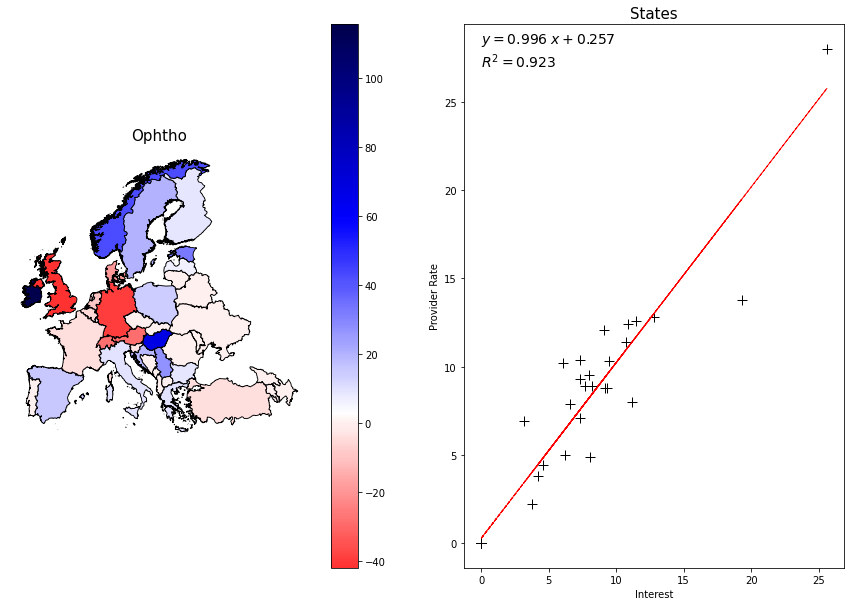

In [17]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 10))
ax1.axis('off')
ax1.set_title("Ophtho", fontdict={'fontsize': '15', 'fontweight' : '3'})
europe.plot(column="Rate_100k_change",
        cmap=new_cmap,
        linewidth=0.9,
        ax=ax1,
        edgecolor='0',
        legend=True)

ax3.set_title('States', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax3.set_xlabel("Interest")
ax3.set_ylabel("Provider Rate")
x = europe["Rate_100k_2017"]
y = europe["Rate_100k_2020"]

ax3.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax3.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax3.text(0, 27, text,
fontsize=14)

In [18]:
fig1 = px.scatter(europe, title = "EU Ophto Provider Change", x="Rate_100k_2017",y="Rate_100k_2020", color="Rate_100k_change", trendline="ols", trendline_scope="overall", hover_data=["NAME"])
fig1.show()